In [1]:
##############################################
# 1. Import Libraries
##############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

In [2]:
##############################################
# 2. Load Datasets
##############################################

In [3]:
customers    = pd.read_csv("CUSTOMERS.csv")
orders       = pd.read_csv("ORDERS.csv")
products     = pd.read_csv("PRODUCTS.csv")
geolocation  = pd.read_csv("GEO_LOCATION.csv")
order_items  = pd.read_csv("ORDER_ITEMS.csv")
ratings      = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
payments     = pd.read_csv("ORDER_PAYMENTS.csv")
sellers      = pd.read_csv("SELLERS.csv")

In [4]:
##############################################
# 3. Data Exploration & Cleaning
##############################################

In [5]:
# Display the first few rows for a quick look at each dataset
print("Customers Sample:\n", customers.head())
print("Orders Sample:\n", orders.head())
print("Products Sample:\n", products.head())
print("Geolocation Sample:\n", geolocation.head())
print("Order Items Sample:\n", order_items.head())
print("Ratings Sample:\n", ratings.head())
print("Payments Sample:\n", payments.head())
print("Sellers Sample:\n", sellers.head())

Customers Sample:
                         customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix customer_city  customer_state  
0                     14409      Adilabad  Andhra Pradesh  
1                      9790         Adoni  Andhra Pradesh  
2                      1151  Akkarampalle  Andhra Pradesh  
3                      8775   Akkayapalle  Andhra Pradesh  
4                     13056         Alwal  Andhra Pradesh  
Orders Sample:
                            order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b

In [6]:
# Check for missing values in each dataset
print("Missing Values in Customers:\n", customers.isnull().sum())
print("Missing Values in Orders:\n", orders.isnull().sum())
print("Missing Values in Products:\n", products.isnull().sum())
print("Missing Values in Geolocation:\n", geolocation.isnull().sum())
print("Missing Values in Order Items:\n", order_items.isnull().sum())
print("Missing Values in Payments:\n", payments.isnull().sum())
print("Missing Values in Ratings:\n", ratings.isnull().sum())
print("Missing Values in Sellers:\n", sellers.isnull().sum())

Missing Values in Customers:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Missing Values in Orders:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Missing Values in Products:
 product_id                      0
product_category_name         623
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
Missing Values in Geolocation:
 geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng  

In [7]:
# Check for duplicates in each dataset
print("Duplicate rows in Customers:", customers.duplicated().sum())
print("Duplicate rows in Orders:", orders.duplicated().sum())
print("Duplicate rows in Products:", products.duplicated().sum())
print("Duplicate rows in Geolocation:", geolocation.duplicated().sum())
print("Duplicate rows in Order Items:", order_items.duplicated().sum())
print("Duplicate rows in Payments:", payments.duplicated().sum())
print("Duplicate rows in Ratings:", ratings.duplicated().sum())
print("Duplicate rows in Sellers:", sellers.duplicated().sum())

# Calculate a new column for total payment (price + freight_value)
order_items['payment'] = order_items['price'] + order_items['freight_value']

Duplicate rows in Customers: 0
Duplicate rows in Orders: 0
Duplicate rows in Products: 0
Duplicate rows in Geolocation: 0
Duplicate rows in Order Items: 0
Duplicate rows in Payments: 0
Duplicate rows in Ratings: 0
Duplicate rows in Sellers: 0


In [8]:
##############################################
# 4. High-Level Metrics Calculation
##############################################

In [9]:
# Calculate key metrics
total_revenue         = order_items['payment'].sum()
total_quantity        = order_items['order_item_id'].count()
total_products        = products['product_id'].nunique()
total_categories      = products['product_category_name'].nunique()
total_sellers         = sellers['seller_id'].nunique()
total_locations       = geolocation['geolocation_city'].nunique()
total_payment_methods = payments['payment_type'].nunique()

print(f"Total Revenue: {total_revenue}")
print(f"Total Quantity Sold: {total_quantity}")
print(f"Total Products: {total_products}")
print(f"Total Categories: {total_categories}")
print(f"Total Sellers: {total_sellers}")
print(f"Total Locations: {total_locations}")
print(f"Total Payment Methods: {total_payment_methods}")

Total Revenue: 15843553.24
Total Quantity Sold: 112650
Total Products: 32951
Total Categories: 71
Total Sellers: 3095
Total Locations: 3809
Total Payment Methods: 5


In [10]:
##############################################
# 5. Analysis of Customer Acquisition
##############################################

In [11]:
# New Customers Acquired Every Month
# Convert the order purchase timestamp to datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Merge customers with orders to get transaction details per customer
merged_df = pd.merge(customers, orders, on='customer_id')
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
# Create a year-month period for aggregation
merged_df['year-month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')
orders['year-month']    = orders['order_purchase_timestamp'].dt.to_period('M')

# Determine the first (minimum) transaction date for each customer per month
min_monthly_transaction_df = merged_df.groupby(['customer_unique_id', 'year-month']).agg(
    min_transaction_date_month=('order_purchase_timestamp', 'min')
).reset_index()

# Also get the overall first transaction date per customer
min_overall_transaction_df = merged_df.groupby('customer_unique_id').agg(
    min_transaction_date=('order_purchase_timestamp', 'min')
).reset_index()

# Merge these to classify customers as NEW or EXISTING for that month
customer_status_df = pd.merge(min_monthly_transaction_df, min_overall_transaction_df, on='customer_unique_id', how='left')
customer_status_df['customer_category'] = customer_status_df.apply(
    lambda row: 'EXISTING' if row['min_transaction_date_month'] > row['min_transaction_date'] else 'NEW', axis=1
)
# Remove duplicate customer entries; keep the latest classification
customer_status_df = customer_status_df.drop_duplicates(subset="customer_unique_id", keep="last")

# Merge the customer category back into the customers dataframe
customers = pd.merge(customers, customer_status_df[["customer_unique_id", "customer_category"]],
                     on='customer_unique_id', how='left')
print("Customers with Category:\n", customers.head())

Customers with Category:
                         customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix customer_city  customer_state customer_category  
0                     14409      Adilabad  Andhra Pradesh               NEW  
1                      9790         Adoni  Andhra Pradesh               NEW  
2                      1151  Akkarampalle  Andhra Pradesh               NEW  
3                      8775   Akkayapalle  Andhra Pradesh               NEW  
4                     13056         Alwal  Andhra Pradesh               NEW  


In [12]:
# Aggregate to count new customers per month
merged_df = pd.merge(customers, orders, on='customer_id')
new_customers_per_month = merged_df.groupby('year-month')['customer_unique_id'].nunique().reset_index()
new_customers_per_month.columns = ['Month', 'New Customers']
print("New Customers Acquired Each Month:\n", new_customers_per_month)

New Customers Acquired Each Month:
       Month  New Customers
0   2016-09              4
1   2016-10            321
2   2016-12              1
3   2017-01            765
4   2017-02           1755
5   2017-03           2642
6   2017-04           2372
7   2017-05           3625
8   2017-06           3180
9   2017-07           3947
10  2017-08           4246
11  2017-09           4212
12  2017-10           4561
13  2017-11           7430
14  2017-12           5603
15  2018-01           7166
16  2018-02           6569
17  2018-03           7115
18  2018-04           6882
19  2018-05           6814
20  2018-06           6128
21  2018-07           6230
22  2018-08           6460
23  2018-09             14
24  2018-10              4


In [13]:
##############################################
# 6. Customer Retention Analysis (Month-on-Month)
##############################################

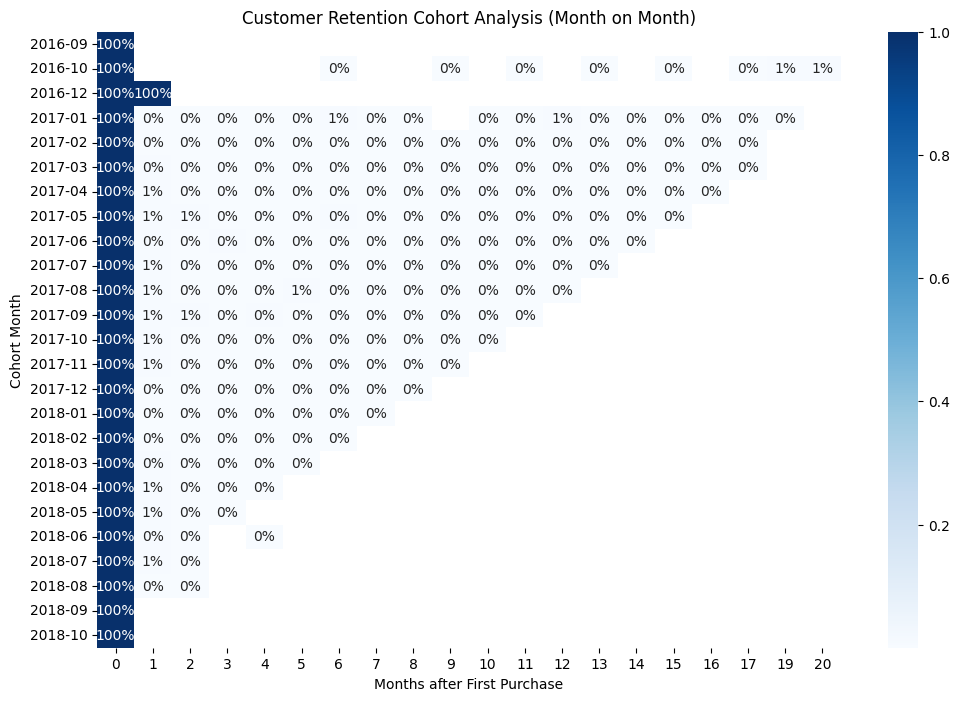

In [14]:
# Merge orders with customers to link purchase history to customer details
data = pd.merge(orders, customers, on='customer_id')
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Define the cohort month (month of first purchase per customer)
data['cohort_month'] = data.groupby('customer_unique_id')['order_purchase_timestamp']\
                           .transform('min').dt.to_period('M')
# Define the activity month (order month)
data['order_month'] = data['order_purchase_timestamp'].dt.to_period('M')
# Compute the number of months between first purchase and each order (cohort index)
data['cohort_index'] = (data['order_month'] - data['cohort_month']).apply(lambda x: x.n)

# Create the cohort table counting unique customers in each cohort and period offset
cohort_data = data.groupby(['cohort_month', 'cohort_index'])\
                  .agg({'customer_unique_id': 'nunique'}).reset_index()
cohort_table = cohort_data.pivot_table(index='cohort_month', columns='cohort_index',
                                       values='customer_unique_id')
# Calculate retention rate by dividing each cell by the first-month customer count
cohort_size = cohort_table.iloc[:, 0]
retention = cohort_table.divide(cohort_size, axis=0)

# Plot a heatmap of the retention table
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='0.00%', cmap='Blues')
plt.title('Customer Retention Cohort Analysis (Month on Month)')
plt.xlabel('Months after First Purchase')
plt.ylabel('Cohort Month')
plt.show()

In [15]:
#############################################
# 7. Revenue Analysis: New vs Existing Customers (Monthly)
##############################################

In [16]:
# Merge orders with customers (including customer_category) and then with order_items to attach revenue details
orders_merged      = pd.merge(orders, customers, on='customer_id')
order_items_merged = pd.merge(order_items, orders_merged, on='order_id')
monthly_revenue    = order_items_merged.groupby(['year-month', 'customer_category'])\
                                       .agg({'payment': 'sum'}).reset_index()
monthly_revenue.columns = ['Month', 'Customer Type', 'Total Revenue']

# Pivot the table to compare new and existing customers side by side
revenue_pivot = monthly_revenue.pivot(index='Month', columns='Customer Type', values='Total Revenue').fillna(0)
print("Monthly Revenue from New vs Existing Customers:\n", revenue_pivot)

Monthly Revenue from New vs Existing Customers:
 Customer Type  EXISTING         NEW
Month                              
2016-09            0.00      354.75
2016-10          928.25    55880.59
2016-12           19.62        0.00
2017-01         5179.65   132008.84
2017-02         5937.72   280342.90
2017-03        17278.78   414769.81
2017-04        17170.56   395251.68
2017-05        24268.02   561922.93
2017-06        24771.20   478191.84
2017-07        26682.00   558289.62
2017-08        28907.27   639297.33
2017-09        30407.81   689991.10
2017-10        31025.83   738286.54
2017-11        42613.70  1136530.07
2017-12        30867.43   832679.80
2018-01        39447.58  1067854.31
2018-02        35195.11   951713.85
2018-03        31204.61  1123922.21
2018-04        40766.60  1118931.44
2018-05        38847.84  1110933.98
2018-06        35943.35   986733.76
2018-07        37103.88  1021624.15
2018-08        24171.00   979137.47
2018-09          166.46        0.00


In [17]:
##############################################
# 8. Sales Trends & Seasonality Analysis
##############################################

In [18]:
# Monthly Sales Trends (Revenue and Quantity)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
order_items_merged = pd.merge(order_items, orders, on='order_id')
monthly_sales = order_items_merged.groupby('order_purchase_month')\
                                  .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
monthly_sales.columns = ['Month', 'Total Revenue', 'Total Quantity']
print("Monthly Sales Trends:\n", monthly_sales)

Monthly Sales Trends:
       Month  Total Revenue  Total Quantity
0   2016-09         354.75               6
1   2016-10       56808.84             363
2   2016-12          19.62               1
3   2017-01      137188.49             955
4   2017-02      286280.62            1951
5   2017-03      432048.59            3000
6   2017-04      412422.24            2684
7   2017-05      586190.95            4136
8   2017-06      502963.04            3583
9   2017-07      584971.62            4519
10  2017-08      668204.60            4910
11  2017-09      720398.91            4831
12  2017-10      769312.37            5322
13  2017-11     1179143.77            8665
14  2017-12      863547.23            6308
15  2018-01     1107301.89            8208
16  2018-02      986908.96            7672
17  2018-03     1155126.82            8217
18  2018-04     1159698.04            7975
19  2018-05     1149781.82            7925
20  2018-06     1022677.11            7078
21  2018-07     1058728.03     

In [19]:
#  Sales by Product Category
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
category_sales = order_items_products.groupby(['product_category_name'])\
                                     .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
category_sales.columns = ['Category', 'Total Revenue', 'Total Quantity']
print("Sales by Category:\n", category_sales.head())

Sales by Category:
                      Category  Total Revenue  Total Quantity
0  Agro_Industry_And_Commerce       78374.07             212
1            Air_Conditioning       61774.19             297
2                         Art       28247.81             209
3       Arts_And_Craftmanship        2184.14              24
4                       Audio       56398.94             364


In [20]:
# Sales by Location (State)
location_sales = order_items_products.groupby(['customer_state'])\
                                     .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
location_sales.columns = ['State', 'Total Revenue', 'Total Quantity']
print("Sales by Location:\n", location_sales.head())

Sales by Location:
                State  Total Revenue  Total Quantity
0     Andhra Pradesh     9329513.16           69093
1  Arunachal Pradesh      185467.27            1258
2       Chhattisgarh     1076784.03            7106
3              Delhi      578251.81            3751
4                Goa         989.83              10


In [21]:
# Sales by Month (Integer Month from Timestamp)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.month
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
month_sales = order_items_products.groupby(['order_purchase_month'])\
                                  .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
month_sales.columns = ['Month', 'Total Revenue', 'Total Quantity']
print("Sales by Month (numeric):\n", month_sales.head())

Sales by Month (numeric):
    Month  Total Revenue  Total Quantity
0      1     1244490.38            9163
1      2     1273189.58            9623
2      3     1587175.41           11217
3      4     1572120.28           10659
4      5     1735972.77           12061


In [22]:
# Sales by Week (ISO Week Number)
orders['order_purchase_week'] = orders['order_purchase_timestamp'].dt.isocalendar().week
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
week_sales = order_items_products.groupby(['order_purchase_week'])\
                                 .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
week_sales.columns = ['Weeknum', 'Total Revenue', 'Total Quantity']
print("Sales by Week:\n", week_sales.head())

Sales by Week:
    Weeknum  Total Revenue  Total Quantity
0        1      217144.60            1608
1        2      291467.36            2093
2        3      289401.81            2199
3        4      312737.29            2217
4        5      315122.89            2363


In [23]:
# Sales by Day of Week
orders['order_purchase_day'] = orders['order_purchase_timestamp'].dt.weekday
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
day_sales = order_items_products.groupby(['order_purchase_day'])\
                                .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
day_sales.columns = ['DayNum', 'Total Revenue', 'Total Quantity']
print("Sales by Day:\n", day_sales.head())

Sales by Day:
    DayNum  Total Revenue  Total Quantity
0       0     2600533.82           18393
1       1     2532228.11           18237
2       2     2466682.13           17600
3       3     2351584.20           16797
4       4     2281931.02           16039


In [24]:
# Sales by Hour of Day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].dt.hour
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
hour_sales = order_items_products.groupby(['order_purchase_hour'])\
                                 .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
hour_sales.columns = ['Hour', 'Total Revenue', 'Total Quantity']
print("Sales by Hour:\n", hour_sales.head())

Sales by Hour:
    Hour  Total Revenue  Total Quantity
0     0      371018.90            2717
1     1      174479.00            1289
2     2       65526.06             584
3     3       41319.89             314
4     4       28334.08             244


In [25]:
# Sales by Payment Type
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
# Merge with payments to attach payment type details
order_items_products = pd.merge(order_items_merged, payments, on='order_id')
payment_sales = order_items_products.groupby(['payment_type'])\
                                    .agg({'payment': 'sum', 'order_item_id': 'count'}).reset_index()
payment_sales.columns = ['Payment Type', 'Total Revenue', 'Total Quantity']
print("Sales by Payment Type:\n", payment_sales.head())

Sales by Payment Type:
   Payment Type  Total Revenue  Total Quantity
0          UPI     2842240.29           22867
1  credit_card    12723914.88           86769
2   debit_card      215306.74            1691
3      voucher      785081.94            6274


In [26]:
##############################################
# 9. Popularity Analysis: Products & Categories
##############################################

In [27]:
# Popular Products by Month
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
popular_products_month = order_items_products.groupby(['order_purchase_month', 'product_id'])\
                                             .agg({'order_item_id': 'count'}).reset_index()
popular_products_month.columns = ['Month', 'Product ID', 'Total Quantity']
popular_products_month = popular_products_month.sort_values(['Month', 'Total Quantity'], ascending=[True, False])\
                                               .groupby("Month").head(1)
print("Popular Products by Month:\n", popular_products_month.head())

Popular Products by Month:
        Month                        Product ID  Total Quantity
3087       1  aca2eb7d00ea1a7b8ebd4e68314663af             122
9022       2  e53e557d5a159f5aa2c5e995dfdf244b              71
13448      3  aca2eb7d00ea1a7b8ebd4e68314663af              65
17232      4  53b36df67ebb7c41585e8d54d6772e08              85
23250      5  53b36df67ebb7c41585e8d54d6772e08             114


In [28]:
# Popular Products by Seller
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, sellers, on='seller_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
popular_products_seller = order_items_products.groupby(['product_id', 'seller_id'])\
                                              .agg({'order_item_id': 'count'}).reset_index()
popular_products_seller.columns = ['Product ID', 'Seller', 'Total Quantity']
popular_products_seller = popular_products_seller.sort_values(['Seller', 'Total Quantity'], ascending=[True, False])\
                                                 .groupby("Seller").head(1)
print("Popular Products by Seller:\n", popular_products_seller.head())

Popular Products by Seller:
                              Product ID                            Seller  \
21911  a2ff5a97bf95719e38ea2e3b4105bce8  0015a82c2db000af6aaaf3ae2ecb0532   
1104   08574b074924071f4e201e151b152b4e  001cca7ae9ae17fb1caed9dfb1094831   
1226   093cd981b714bcdff182b427d87fc8fc  001e6ad469a905060d959994f1b41e4f   
2949   158102fe543dbaeb84d87811bfe06d0d  002100f778ceb8431b7a1020ff7ab48f   
14082  67f36b3689147d882d2b298fd0715d80  003554e2dce176b5555353e4f3555ac8   

       Total Quantity  
21911               3  
1104              113  
1226                1  
2949               17  
14082               1  


In [29]:
# Popular Products by Customer Location (State)
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, sellers, on='seller_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
popular_products_state = order_items_products.groupby(['product_id', 'customer_state'])\
                                             .agg({'order_item_id': 'count'}).reset_index()
popular_products_state.columns = ['Product ID', 'Customer State', 'Total Quantity']
popular_products_state = popular_products_state.sort_values(['Customer State', 'Total Quantity'], ascending=[True, False])\
                                             .groupby("Customer State").head(1)
print("Popular Products by Customer State:\n", popular_products_state.head())

Popular Products by Customer State:
                              Product ID     Customer State  Total Quantity
37103  aca2eb7d00ea1a7b8ebd4e68314663af     Andhra Pradesh             345
765    03e1c946c0ddfc58724ff262aef08dff  Arunachal Pradesh              12
11734  368c6c730842d78016ad823897a372db       Chhattisgarh              40
18134  53759a2ecddad2bb87a079a1f1519f73              Delhi              22
9268   2a5806f10d0f00e5ad032dd2e3c8806e                Goa               1


In [30]:
# Popular Categories by Month
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
popular_categories_month = order_items_products.groupby(['order_purchase_month', 'product_category_name'])\
                                               .agg({'order_item_id': 'count'}).reset_index()
popular_categories_month.columns = ['Month', 'Category', 'Total Quantity']
popular_categories_month = popular_categories_month.sort_values(['Month', 'Total Quantity'], ascending=[True, False])\
                                                   .groupby("Month").head(1)
print("Popular Categories by Month:\n", popular_categories_month.head())

Popular Categories by Month:
      Month               Category  Total Quantity
6        1         Bed_Bath_Table             896
81       2  Computers_Accessories            1087
138      3         Bed_Bath_Table            1087
206      4         Bed_Bath_Table            1020
275      5         Bed_Bath_Table            1116


In [31]:
# Popular Categories by State
order_items_merged = pd.merge(order_items, orders, on='order_id')
order_items_merged = pd.merge(order_items_merged, customers, on='customer_id')
order_items_products = pd.merge(order_items_merged, products, on='product_id')
popular_categories_state = order_items_products.groupby(['customer_state', 'product_category_name'])\
                                               .agg({'order_item_id': 'count'}).reset_index()
popular_categories_state.columns = ['Customer State', 'Category', 'Total Quantity']
popular_categories_state = popular_categories_state.sort_values(['Customer State', 'Total Quantity'], ascending=[True, False])\
                                                   .groupby("Customer State").head(1)
print("Popular Categories by State:\n", popular_categories_state.head())

Popular Categories by State:
         Customer State        Category  Total Quantity
7       Andhra Pradesh  Bed_Bath_Table            7101
77   Arunachal Pradesh  Bed_Bath_Table             114
132       Chhattisgarh  Bed_Bath_Table             681
229              Delhi   Health_Beauty             328
255                Goa            Auto               1


In [32]:
# Top 10 Most Expensive Products (by Maximum Price)
order_items_merged = pd.merge(order_items, products, on='product_id')
# Group by product to get the maximum price observed
product_prices = order_items_merged.groupby(['product_id', 'product_category_name'])\
                                   .agg({'price': 'max'}).reset_index()
top_10_expensive_products = product_prices.sort_values(by='price', ascending=False).head(10)
print("Top 10 Most Expensive Products:")
print(top_10_expensive_products)

Top 10 Most Expensive Products:
                             product_id product_category_name    price
9253   489ae2aa008f021502940f251d4cce7f            Housewares  6735.00
13438  69c590f7ffc7bf8db97190b6cb6ed62e             Computers  6729.00
3623   1bdf5e6731585cf01aa8169c7028d6ad                   Art  6499.00
20932  a6492cc69376c469ab6f61d8f44de961      Small_Appliances  4799.00
24724  c3ed642d592594bb648ff4a04cee2747      Small_Appliances  4690.00
4872   259037a6a41845e455183f89c5035f18             Computers  4590.00
20407  a1beef8f3992dbd4cd8726796aa69c53   Musical_Instruments  4399.87
13810  6cdf8fc1d741c76586d8b6b15e9eef30        Consoles_Games  4099.99
27961  dd113cb02b2af9c8e5787e8f1f0722f6        Sports_Leisure  4059.00
13341  6902c1962dd19d540807d0ab8fade5c6         Watches_Gifts  3999.90


In [33]:
##############################################
# 10. Revenue Segmentation
##############################################

In [34]:
# Segment Customers Based on Revenue (Deciles)
customer_revenue = orders.merge(order_items, on='order_id')
customer_revenue = customer_revenue.groupby('customer_id')['price'].sum().reset_index()
customer_revenue.columns = ['customer_id', 'total_revenue']
# Divide into deciles
customer_revenue['customer_decile'] = pd.qcut(customer_revenue['total_revenue'], 10, labels=False) + 1
print("Average Revenue by Customer Decile:")
print(customer_revenue.groupby("customer_decile")["total_revenue"].mean())

Average Revenue by Customer Decile:
customer_decile
1      18.380115
2      32.007785
3      45.731682
4      58.973774
5      76.265533
6      96.220313
7     119.723902
8     152.372048
9     212.708984
10    567.454755
Name: total_revenue, dtype: float64


In [35]:
# Segment Sellers Based on Revenue (Deciles)
seller_revenue = order_items.merge(sellers, on='seller_id')
seller_revenue = seller_revenue.groupby('seller_id')['price'].sum().reset_index()
seller_revenue.columns = ['seller_id', 'total_revenue']
seller_revenue['seller_decile'] = pd.qcut(seller_revenue['total_revenue'], 10, labels=False) + 1
print("Average Revenue by Seller Decile:")
print(seller_revenue.groupby("seller_decile")["total_revenue"].mean())

Average Revenue by Seller Decile:
seller_decile
1        44.184226
2       116.870259
3       216.805581
4       378.267573
5       657.364903
6      1065.122006
7      1779.668058
8      3341.154161
9      6653.668188
10    29623.144387
Name: total_revenue, dtype: float64


In [36]:
##############################################
# 11. Cross-Selling Analysis: Products Sold Together
##############################################

In [37]:
# Group product_ids for each order into a list
order_products = order_items.groupby('order_id')['product_id'].apply(list)
comb_list = []

# For each order, generate pairs and triplets of products (you can adjust the tuple size)
for prod_list in order_products:
    # Generate all possible pairs
    comb_list.extend(combinations(prod_list, 2))
    # Generate all possible triplets
    comb_list.extend(combinations(prod_list, 3))

# Count frequency of each combination
comb_count = Counter(comb_list)
top_combinations = comb_count.most_common(10)
print("Top 10 Product Combinations Sold Together:")
for comb, count in top_combinations:
    print(f"Combination: {comb}, Count: {count}")

Top 10 Product Combinations Sold Together:
Combination: ('ee3d532c8a438679776d222e997606b3', 'ee3d532c8a438679776d222e997606b3', 'ee3d532c8a438679776d222e997606b3'), Count: 1140
Combination: ('9571759451b1d780ee7c15012ea109d4', '9571759451b1d780ee7c15012ea109d4', '9571759451b1d780ee7c15012ea109d4'), Count: 1140
Combination: ('422879e10f46682990de24d770e7f83d', '422879e10f46682990de24d770e7f83d', '422879e10f46682990de24d770e7f83d'), Count: 476
Combination: ('89b190a046022486c635022524a974a8', '89b190a046022486c635022524a974a8', '89b190a046022486c635022524a974a8'), Count: 465
Combination: ('37eb69aca8718e843d897aa7b82f462d', '37eb69aca8718e843d897aa7b82f462d', '37eb69aca8718e843d897aa7b82f462d'), Count: 455
Combination: ('05b515fdc76e888aada3c6d66c201dff', '05b515fdc76e888aada3c6d66c201dff', '270516a3f41dc035aa87d220228f844c'), Count: 405
Combination: ('44a5d24dd383324a421569ca697b13c2', '44a5d24dd383324a421569ca697b13c2', '44a5d24dd383324a421569ca697b13c2'), Count: 364
Combination: ('05

In [38]:
##############################################
# 12. Payment Analysis
##############################################

In [39]:
# How Customers Are Paying: Summary by Payment Type
payment_summary = payments.groupby('payment_type').agg({
    'payment_sequential': 'count',
    'payment_value': 'sum'
}).reset_index()
payment_summary.columns = ['payment_type', 'count', 'total_payment_value']
print("Payment Summary:")
print(payment_summary)

Payment Summary:
  payment_type  count  total_payment_value
0          UPI  19784           2869361.27
1  credit_card  76795          12542084.19
2   debit_card   1529            217989.79
3  not_defined      3                 0.00
4      voucher   5775            379436.87


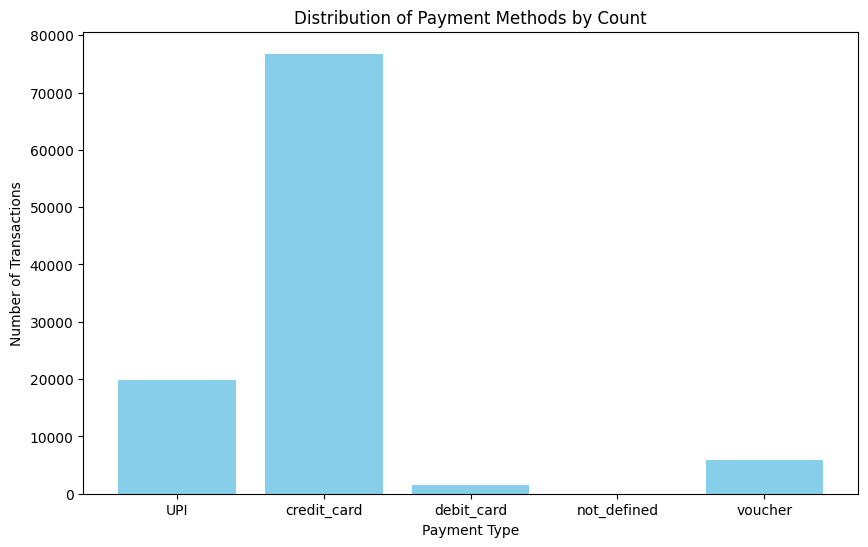

In [40]:
# Plot distribution by count
plt.figure(figsize=(10, 6))
plt.bar(payment_summary['payment_type'], payment_summary['count'], color='skyblue')
plt.title('Distribution of Payment Methods by Count')
plt.xlabel('Payment Type')
plt.ylabel('Number of Transactions')
plt.show()

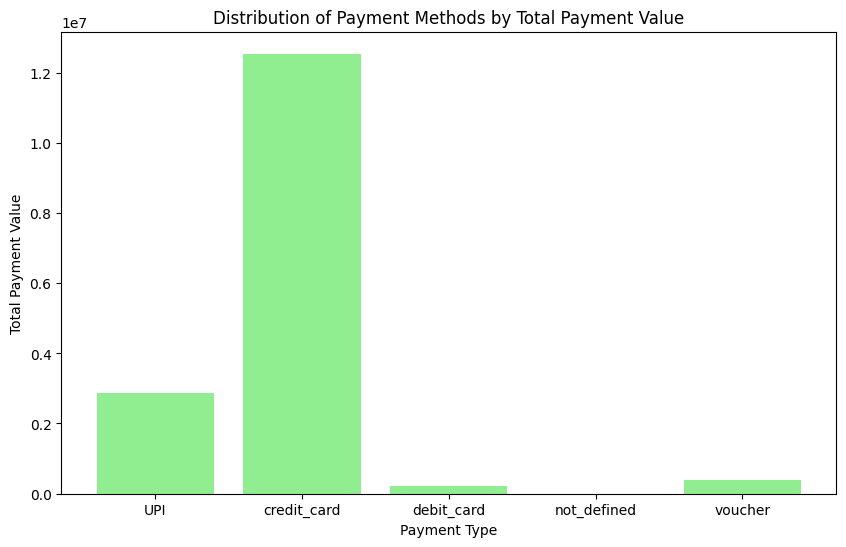

In [41]:
# Plot distribution by total payment value
plt.figure(figsize=(10, 6))
plt.bar(payment_summary['payment_type'], payment_summary['total_payment_value'], color='lightgreen')
plt.title('Distribution of Payment Methods by Total Payment Value')
plt.xlabel('Payment Type')
plt.ylabel('Total Payment Value')
plt.show()

In [42]:
# Which Payment Channels Are Used by Most Customers?
# Merge payments with orders to get customer details
payment_customer = pd.merge(payments, orders[['order_id', 'customer_id']], on='order_id')
unique_customers_payment = payment_customer.groupby('payment_type')['customer_id'].nunique().reset_index()
unique_customers_payment.columns = ['payment_type', 'unique_customers']
print("Unique Customers per Payment Method:")
print(unique_customers_payment)

Unique Customers per Payment Method:
  payment_type  unique_customers
0          UPI             19784
1  credit_card             76505
2   debit_card              1528
3  not_defined                 3
4      voucher              3866


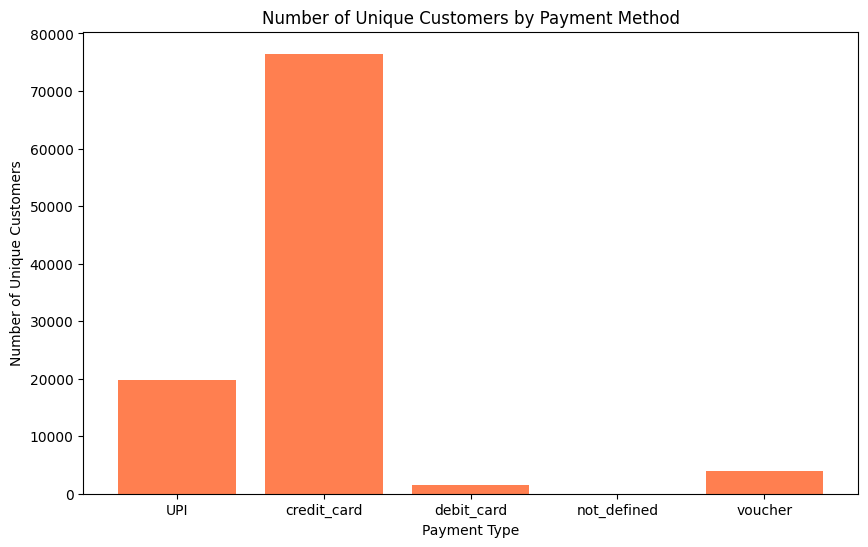

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(unique_customers_payment['payment_type'], unique_customers_payment['unique_customers'], color='coral')
plt.title('Number of Unique Customers by Payment Method')
plt.xlabel('Payment Type')
plt.ylabel('Number of Unique Customers')
plt.show()

In [44]:
##############################################
# 13. Ratings Analysis
##############################################

Top 10 Maximum Rated Categories:
                    product_category_name  review_score
11                      Cds_Dvds_Musicals      4.642857
29              Fashion_Childrens_Clothes      4.500000
8                  Books_General_Interest      4.439421
9                          Books_Imported      4.400000
22                Costruction_Tools_Tools      4.359223
10                        Books_Technical      4.338290
53                    Luggage_Accessories      4.309524
37                             Food_Drink      4.303571
64  Small_Appliances_Home_Oven_And_Coffee      4.302632
32                          Fashion_Sport      4.258065


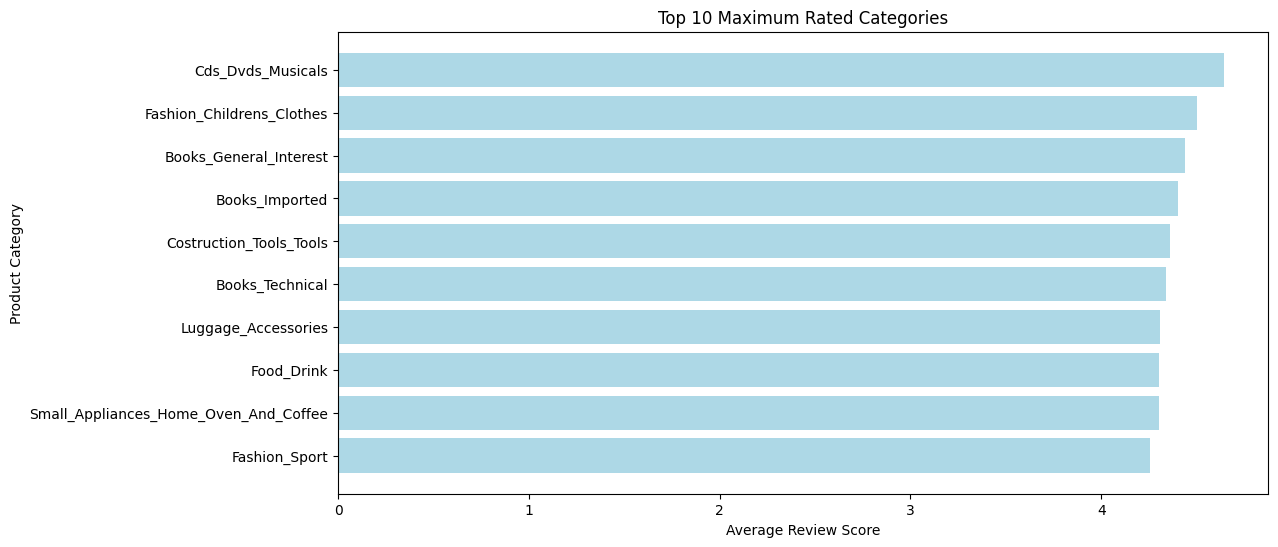

In [45]:
# Top 10 Maximum & Minimum Rated Categories
# Merge order_items with products (to get category) and ratings (to get review scores)
order_items_products = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
merged_data = pd.merge(order_items_products, orders[['order_id']], on='order_id')
merged_data = pd.merge(merged_data, ratings[['order_id', 'review_score']], on='order_id')

# Calculate the average review score for each category
category_ratings = merged_data.groupby('product_category_name')['review_score'].mean().reset_index()

# Top 10 maximum rated categories
top_10_max_rated = category_ratings.sort_values(by='review_score', ascending=False).head(10)
print("Top 10 Maximum Rated Categories:")
print(top_10_max_rated)
plt.figure(figsize=(12, 6))
plt.barh(top_10_max_rated['product_category_name'], top_10_max_rated['review_score'], color='lightblue')
plt.title('Top 10 Maximum Rated Categories')
plt.xlabel('Average Review Score')
plt.ylabel('Product Category')
plt.gca().invert_yaxis()
plt.show()


Top 10 Minimum Rated Categories:
     product_category_name  review_score
61   Security_And_Services      2.500000
23     Diapers_And_Hygiene      3.256410
46          Home_Comfort_2      3.366667
57        Office_Furniture      3.484421
30   Fashion_Male_Clothing      3.621212
34         Fixed_Telephony      3.671698
58          Party_Supplies      3.767442
27  Fashio_Female_Clothing      3.780000
52              La_Cuisine      3.785714
4                    Audio      3.808219


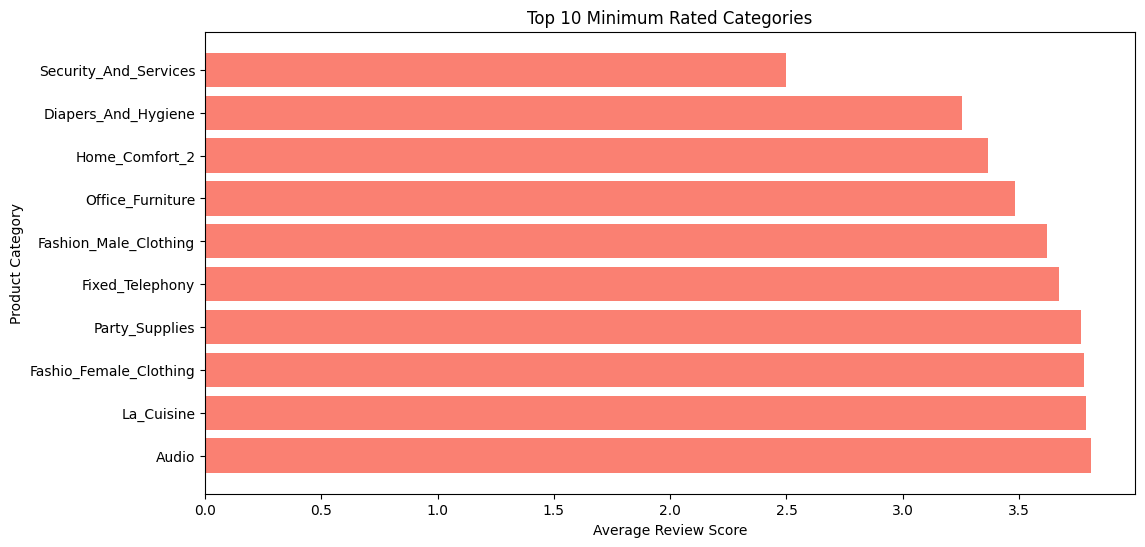

In [46]:
# Top 10 minimum rated categories
top_10_min_rated = category_ratings.sort_values(by='review_score', ascending=True).head(10)
print("\nTop 10 Minimum Rated Categories:")
print(top_10_min_rated)
plt.figure(figsize=(12, 6))
plt.barh(top_10_min_rated['product_category_name'], top_10_min_rated['review_score'], color='salmon')
plt.title('Top 10 Minimum Rated Categories')
plt.xlabel('Average Review Score')
plt.ylabel('Product Category')
plt.gca().invert_yaxis()
plt.show()

Top 10 Maximum Rated Products:
                             product_id  review_score
0      00066f42aeeb9f3007548bb9d3f33c38           5.0
17330  86743ff92eee3d16b7df59cddd583b8c           5.0
17345  868ceb027ab706a4dee42e2220006b85           5.0
17343  868969d3a93aeeab7bfcd4fc3d3d65de           5.0
17342  868766ed2172644fdd977d6bd395a107           5.0
17340  8684bd8f93b4f4038d07188a23811e93           5.0
17335  867c96d2bb67aba6500a4c509cf76072           5.0
17334  867b820367ec206b38a357f2c12454b7           5.0
17333  867901d7e8488fb97f1fb538c09d476e           5.0
17325  865bfa00c1dad8f4146d3c2765f051ca           5.0


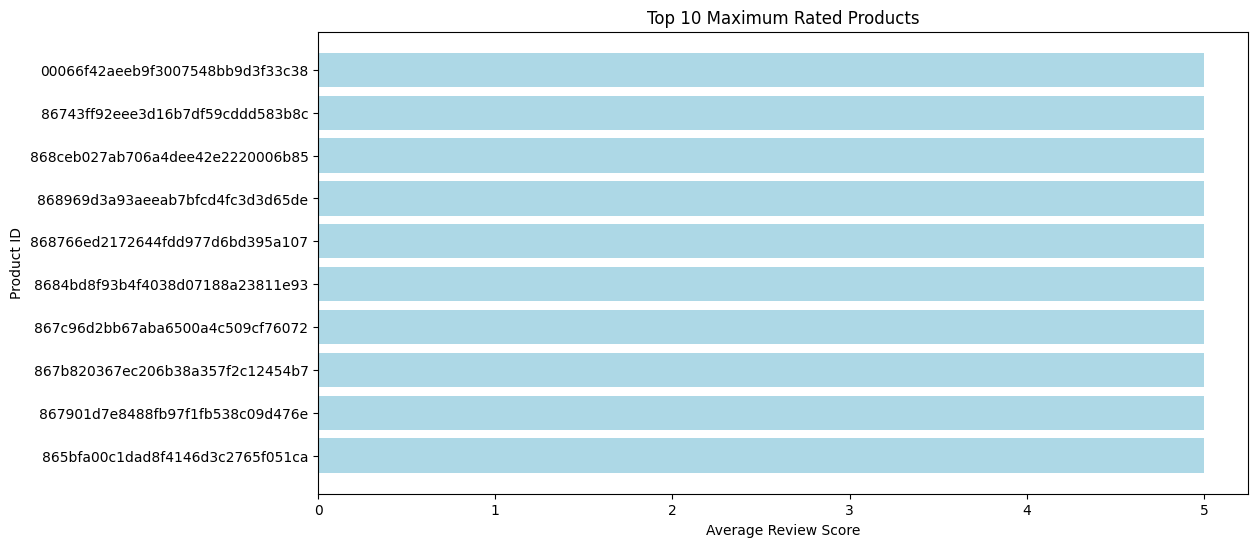

In [47]:
# Top 10 Maximum & Minimum Rated Products
merged_data = pd.merge(order_items, orders[['order_id']], on='order_id')
merged_data = pd.merge(merged_data, ratings[['order_id', 'review_score']], on='order_id')
product_ratings = merged_data.groupby('product_id')['review_score'].mean().reset_index()

# Top 10 maximum rated products
top_10_max_rated_products = product_ratings.sort_values(by='review_score', ascending=False).head(10)
print("Top 10 Maximum Rated Products:")
print(top_10_max_rated_products)
plt.figure(figsize=(12, 6))
plt.barh(top_10_max_rated_products['product_id'], top_10_max_rated_products['review_score'], color='lightblue')
plt.title('Top 10 Maximum Rated Products')
plt.xlabel('Average Review Score')
plt.ylabel('Product ID')
plt.gca().invert_yaxis()
plt.show()


Top 10 Minimum Rated Products:
                             product_id  review_score
11572  592cc6634d2c783d297effc0b828bc37           1.0
5376   28c95d7653177449fd4b6fc7adb63ce9           1.0
5378   28d6d6a10ceb0636ae572e7efafef612           1.0
5379   28d7da9ebe96bfda54aed060b68b23a1           1.0
18040  8c4e5e50a08a443b7fbad34ad7587625           1.0
18039  8c4dc358af6e14174f2114be62c18f37           1.0
18034  8c4456c061013adccb1ba4cbce2d0365           1.0
18030  8c35dc99b37ba51780800ba049ed3616           1.0
5409   28fe66c8a81afe9be7829f40a5fae9ee           1.0
30663  ee37349d258101b9d573a256d1401ff7           1.0


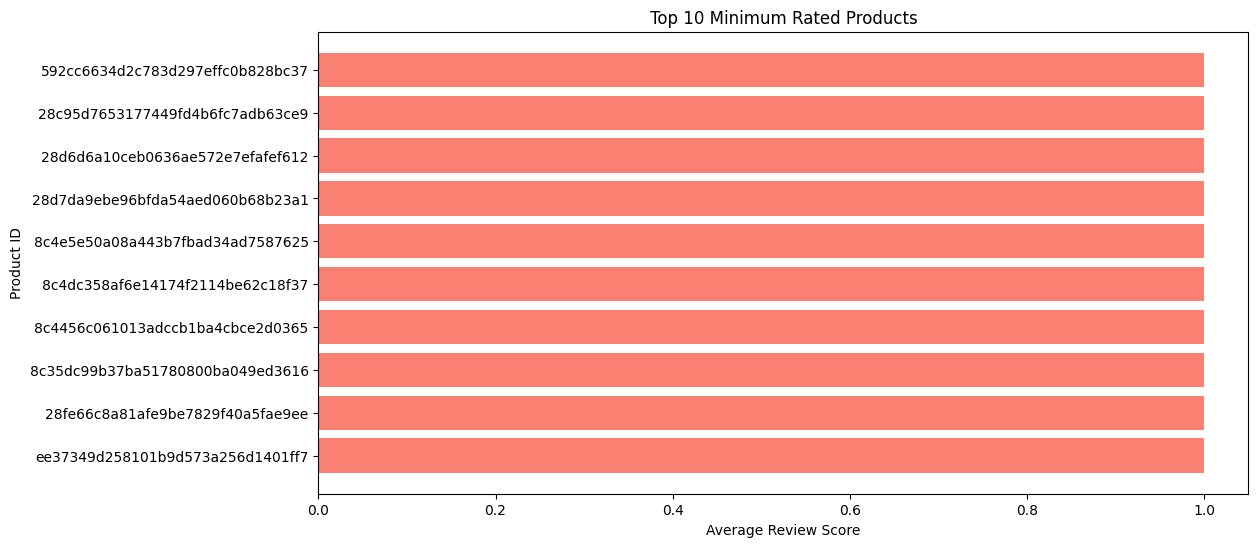

In [48]:
# Top 10 minimum rated products
top_10_min_rated_products = product_ratings.sort_values(by='review_score', ascending=True).head(10)
print("\nTop 10 Minimum Rated Products:")
print(top_10_min_rated_products)
plt.figure(figsize=(12, 6))
plt.barh(top_10_min_rated_products['product_id'], top_10_min_rated_products['review_score'], color='salmon')
plt.title('Top 10 Minimum Rated Products')
plt.xlabel('Average Review Score')
plt.ylabel('Product ID')
plt.gca().invert_yaxis()
plt.show()

In [49]:
# Average Rating by Location, Seller, Product, Category, Month
# Merge datasets to bring together ratings, orders, products, and seller/location details
merged_data = pd.merge(ratings, orders[['order_id', 'order_purchase_timestamp', 'customer_id']], on='order_id')
merged_data = pd.merge(merged_data, order_items[['order_id', 'product_id', 'seller_id']], on='order_id')
merged_data = pd.merge(merged_data, products[['product_id', 'product_category_name']], on='product_id')
merged_data = pd.merge(merged_data, sellers[['seller_id', 'seller_city', 'seller_state']], on='seller_id')

# Convert the order timestamp to datetime and extract month-year
merged_data['order_purchase_timestamp'] = pd.to_datetime(merged_data['order_purchase_timestamp'])
merged_data['month_year'] = merged_data['order_purchase_timestamp'].dt.to_period('M')

In [50]:
# Average Rating by City and State (Seller Location)
avg_rating_city  = merged_data.groupby('seller_city')['review_score'].mean().reset_index()
avg_rating_state = merged_data.groupby('seller_state')['review_score'].mean().reset_index()
print("Average Rating by City:")
print(avg_rating_city)
print("\nAverage Rating by State:")
print(avg_rating_state)

Average Rating by City:
      seller_city  review_score
0       Aadityana      1.000000
1      Aarambhada      4.320000
2         Achabal      4.000000
3          Adalaj      4.437500
4        Adilabad      4.013889
..            ...           ...
529      Yellandu      4.166667
530    Yemmiganur      4.152174
531     Zahirabad      3.522843
532  Ziauddin Pur      3.879167
533          Ziro      3.466667

[534 rows x 2 columns]

Average Rating by State:
         seller_state  review_score
0      Andhra Pradesh      4.019711
1   Arunachal Pradesh      4.154248
2        Chhattisgarh      4.111963
3               Delhi      3.884944
4             Gujarat      3.936198
5             Haryana      4.074761
6    Himachal Pradesh      4.149554
7     Jammu & Kashmir      4.043765
8           Karnataka      4.033441
9              Kerala      4.243902
10     Madhya Pradesh      4.034047
11        Maharashtra      4.004762
12             Orissa      4.229412
13             Punjab      3.523810
14

In [51]:
# Average Rating by Seller
avg_rating_seller = merged_data.groupby('seller_id')['review_score'].mean().reset_index()
print("\nAverage Rating by Seller:")
print(avg_rating_seller)


Average Rating by Seller:
                             seller_id  review_score
0     0015a82c2db000af6aaaf3ae2ecb0532      3.666667
1     001cca7ae9ae17fb1caed9dfb1094831      3.874477
2     001e6ad469a905060d959994f1b41e4f      1.000000
3     002100f778ceb8431b7a1020ff7ab48f      3.982143
4     003554e2dce176b5555353e4f3555ac8      5.000000
...                                ...           ...
3090  ffcfefa19b08742c5d315f2791395ee5      1.000000
3091  ffdd9f82b9a447f6f8d4b91554cc7dd3      4.250000
3092  ffeee66ac5d5a62fe688b9d26f83f534      4.214286
3093  fffd5413c0700ac820c7069d66d98c89      3.885246
3094  ffff564a4f9085cd26170f4732393726      2.100000

[3095 rows x 2 columns]


In [52]:
# Average Rating by Product
avg_rating_product = merged_data.groupby('product_id')['review_score'].mean().reset_index()
print("\nAverage Rating by Product:")
print(avg_rating_product)


Average Rating by Product:
                             product_id  review_score
0      00066f42aeeb9f3007548bb9d3f33c38           5.0
1      00088930e925c41fd95ebfe695fd2655           4.0
2      0009406fd7479715e4bef61dd91f2462           1.0
3      000b8f95fcb9e0096488278317764d19           5.0
4      000d9be29b5207b54e86aa1b1ac54872           5.0
...                                 ...           ...
32946  fff6177642830a9a94a0f2cba5e476d1           4.5
32947  fff81cc3158d2725c0655ab9ba0f712c           4.0
32948  fff9553ac224cec9d15d49f5a263411f           5.0
32949  fffdb2d0ec8d6a61f0a0a0db3f25b441           5.0
32950  fffe9eeff12fcbd74a2f2b007dde0c58           4.0

[32951 rows x 2 columns]


In [53]:
# Average Rating by Category
avg_rating_category = merged_data.groupby('product_category_name')['review_score'].mean().reset_index()
print("\nAverage Rating by Category:")
print(avg_rating_category)


Average Rating by Category:
         product_category_name  review_score
0   Agro_Industry_And_Commerce      4.000000
1             Air_Conditioning      3.919192
2                          Art      3.918660
3        Arts_And_Craftmanship      4.125000
4                        Audio      3.808219
..                         ...           ...
66                  Stationery      4.181386
67      Tablets_Printing_Image      4.048193
68                   Telephony      3.935604
69                        Toys      4.138667
70               Watches_Gifts      4.002000

[71 rows x 2 columns]


In [54]:
#  Average Rating by Month
avg_rating_month = merged_data.groupby('month_year')['review_score'].mean().reset_index()
print("\nAverage Rating by Month:")
print(avg_rating_month)


Average Rating by Month:
   month_year  review_score
0     2016-09      1.000000
1     2016-10      3.567935
2     2016-12      5.000000
3     2017-01      4.052795
4     2017-02      4.042813
5     2017-03      4.041722
6     2017-04      3.987375
7     2017-05      4.118364
8     2017-06      4.118265
9     2017-07      4.126835
10    2017-08      4.193997
11    2017-09      4.123510
12    2017-10      4.041162
13    2017-11      3.830450
14    2017-12      3.941139
15    2018-01      3.932470
16    2018-02      3.718585
17    2018-03      3.676709
18    2018-04      4.059972
19    2018-05      4.119723
20    2018-06      4.176595
21    2018-07      4.212087
22    2018-08      4.206897
23    2018-09      1.000000
